<a href="https://colab.research.google.com/github/XiaoshanZhou624/A-star-with-GUI-for-human-inputs/blob/main/A_star_with_GUI_for_human_inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue

# Define a simple environment (10x10 grid)
GRID_SIZE = (10, 10)
env = np.zeros(GRID_SIZE)

# Updated obstacles
obstacles = [
    (6, 0), (2, 1), (1, 3), (4, 3), (6, 3), (2, 5), (4, 5), (6, 6), (8, 6), (2, 9)
]
for obstacle in obstacles:
    env[obstacle] = -1  # Mark as obstacle

# Delivery points
delivery_points = [(1, 7), (9, 2), (7, 0)]
for point in delivery_points:
    env[point] = 2  # Mark as delivery points

# Vehicles with updated starting positions
class Vehicle:
    def __init__(self, id, position, velocity=1):
        self.id = id
        self.position = position
        self.velocity = velocity
        self.task_queue = []
        self.current_task = None

vehicles = [
    Vehicle(0, (1, 2), velocity=1),
    Vehicle(1, (2, 6), velocity=1),
    Vehicle(2, (6, 9), velocity=1),
]

# Mark the starting positions of the vehicles
for vehicle in vehicles:
    env[vehicle.position] = 1  # Mark starting positions with '1'

# Define A* pathfinding algorithm
def a_star_search(start, goal, grid):
    rows, cols = grid.shape
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {}
    g_score = {pos: float('inf') for pos in np.ndindex(grid.shape)}
    g_score[start] = 0
    f_score = {pos: float('inf') for pos in np.ndindex(grid.shape)}
    f_score[start] = heuristic(start, goal)

    while not open_set.empty():
        _, current = open_set.get()

        if current == goal:
            return reconstruct_path(came_from, current)

        for neighbor in get_neighbors(current, rows, cols, grid):
            tentative_g_score = g_score[current] + 1  # All edges have weight 1
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                open_set.put((f_score[neighbor], neighbor))

    return []  # Return an empty path if no path found

def heuristic(pos, goal):
    return abs(pos[0] - goal[0]) + abs(pos[1] - goal[1])  # Manhattan distance

def get_neighbors(pos, rows, cols, grid):
    neighbors = []
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
    for dr, dc in directions:
        nr, nc = pos[0] + dr, pos[1] + dc
        if 0 <= nr < rows and 0 <= nc < cols and grid[nr, nc] != -1:
            neighbors.append((nr, nc))
    return neighbors

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

# Generate trajectories using A* for the vehicles
trajectories = {
    vehicle.id: a_star_search(vehicle.position, delivery_points[vehicle.id], env)
    for vehicle in vehicles
}



Visualization saved as trajectories_high_res.png


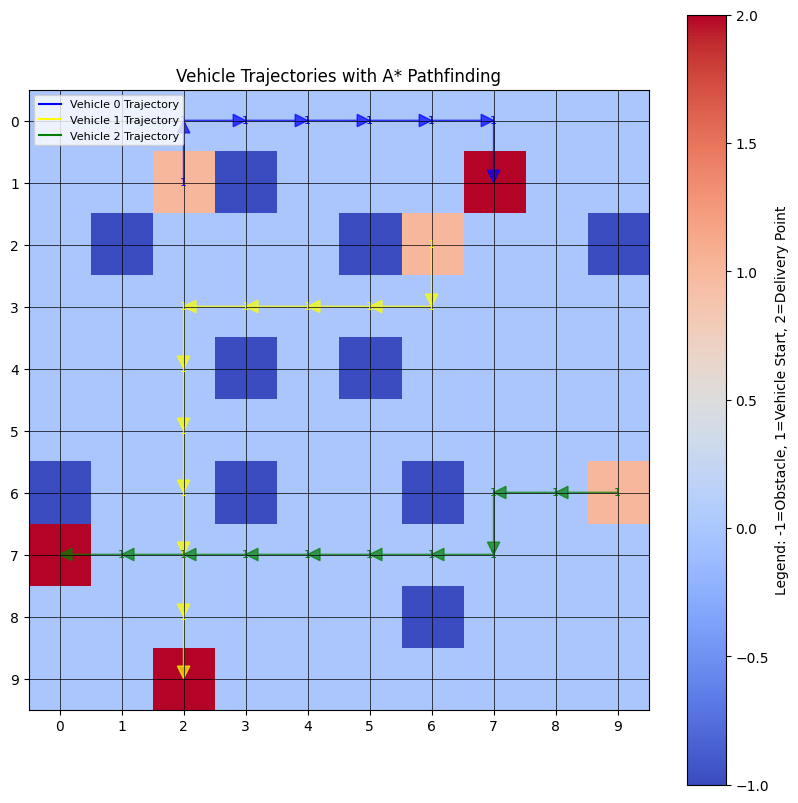

In [ ]:
# Visualization function
def visualize_trajectories_with_velocity(env, trajectories, vehicles):
    """
    Visualize vehicle trajectories with velocity indicators (arrows and numbers).
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(env, cmap="coolwarm", origin="upper")
    plt.title("Vehicle Trajectories with A* Pathfinding")
    plt.colorbar(label="Legend: -1=Obstacle, 1=Vehicle Start, 2=Delivery Point")
    plt.xticks(range(env.shape[1]))
    plt.yticks(range(env.shape[0]))
    plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)

    colors = ['blue', 'yellow', 'green']

    for vehicle_id, trajectory in trajectories.items():
        x_coords, y_coords = zip(*trajectory)
        vehicle = next(v for v in vehicles if v.id == vehicle_id)
        velocity = vehicle.velocity

        # Plot trajectory with velocity indicators
        for i in range(len(trajectory) - 1):
            plt.arrow(
                y_coords[i], x_coords[i],  # Start position
                y_coords[i + 1] - y_coords[i],  # Change in y
                x_coords[i + 1] - x_coords[i],  # Change in x
                color=colors[vehicle_id % len(colors)],
                head_width=0.2,
                head_length=0.2,
                length_includes_head=True,
                alpha=0.7,
            )
            plt.text(
                y_coords[i], x_coords[i],
                f"{velocity}",
                fontsize=8,
                ha='center',
                va='center',
                color=colors[vehicle_id % len(colors)]
            )

    # Add a custom legend for the trajectories
    for idx, color in enumerate(colors):
        plt.plot([], [], color=color, label=f"Vehicle {idx} Trajectory")

    plt.legend(loc="upper left", fontsize=8)

    # Save the figure if a path is provided
    save_path="trajectories_high_res.png"

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Visualization saved as {save_path}")

    plt.show()

# Call the visualization function
visualize_trajectories_with_velocity(env, trajectories, vehicles)


Visualization saved as time_heatmap.png


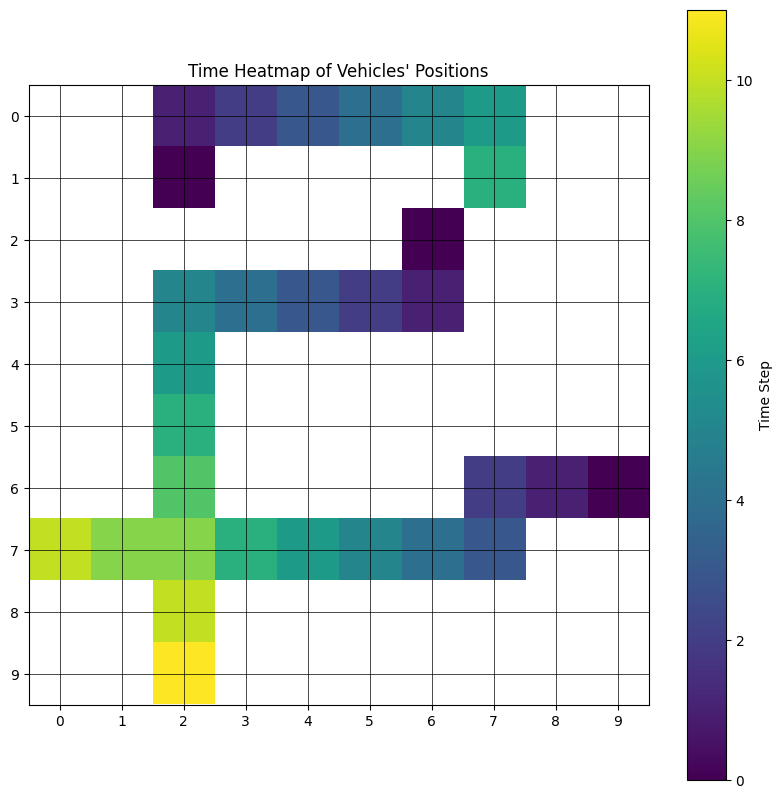

In [ ]:
# Create a time grid for visualization
time_grid = np.full(GRID_SIZE, np.nan)

# Populate the time grid based on trajectories
for vehicle_id, trajectory in trajectories.items():
    for time_step, (x, y) in enumerate(trajectory):
        if np.isnan(time_grid[x, y]):  # Avoid overwriting if another vehicle passes through
            time_grid[x, y] = time_step

# Visualization function for the time heatmap
def visualize_time_heatmap(time_grid):
    """
    Visualize the time grid as a heatmap.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(time_grid, cmap="viridis", origin="upper")
    plt.title("Time Heatmap of Vehicles' Positions")
    plt.colorbar(label="Time Step")
    plt.xticks(range(time_grid.shape[1]))
    plt.yticks(range(time_grid.shape[0]))
    plt.grid(True, which="both", color="black", linestyle="-", linewidth=0.5)

    # Save the figure if a path is provided
    save_path="time_heatmap.png"

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Visualization saved as {save_path}")

    plt.show()

# Call the visualization function
visualize_time_heatmap(time_grid)

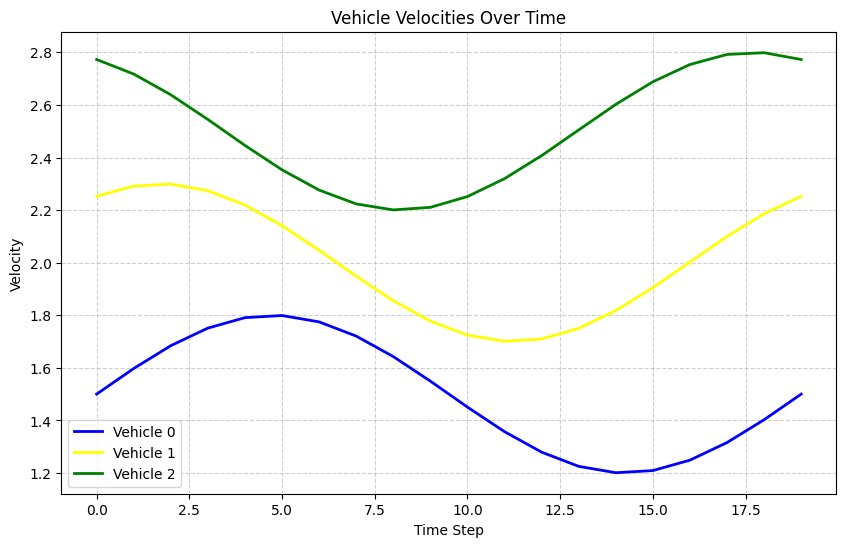

In [ ]:
# Number of vehicles and time steps
num_vehicles = 3
time_steps = 20  # Total number of time steps

# Generate base velocities for each vehicle
base_velocities = [1.5, 2.0, 2.5]  # Different base velocities for vehicles

# Generate smooth velocity curves
time = np.linspace(0, 2 * np.pi, time_steps)  # Time range for smooth curves
vehicle_velocities = {
    vehicle_id: base_velocities[vehicle_id] + 0.3 * np.sin(time + vehicle_id)
    for vehicle_id in range(num_vehicles)
}

# Plotting the velocities over time
plt.figure(figsize=(10, 6))
colors = ['blue', 'yellow', 'green']

for vehicle_id, velocities in vehicle_velocities.items():
    plt.plot(
        range(time_steps),
        velocities,
        label=f"Vehicle {vehicle_id}",
        color=colors[vehicle_id],
        linewidth=2
    )

# Add labels, legend, and title
plt.title("Vehicle Velocities Over Time")
plt.xlabel("Time Step")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Show the plot
plt.show()


Visualization saved as distance.png


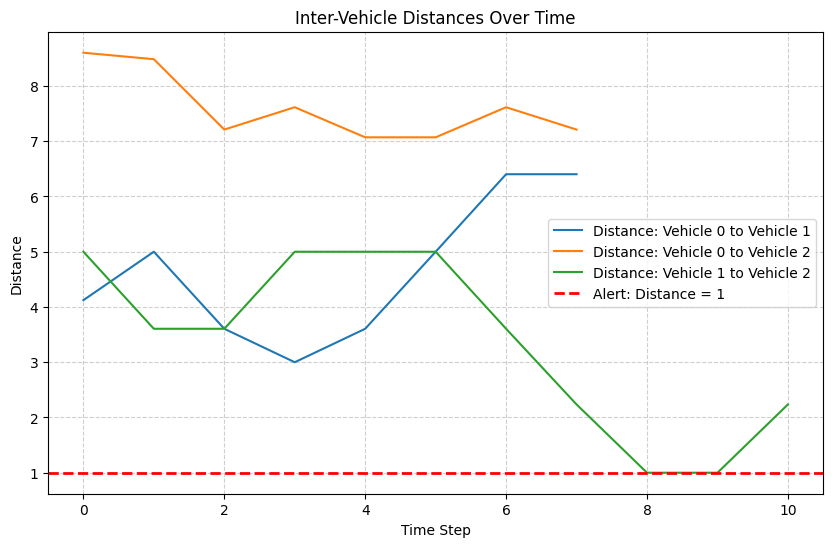

In [ ]:
# Calculate positions over time based on velocities
time_steps = max(len(trajectories[v]) for v in trajectories)
positions = {v: [] for v in trajectories}

for vehicle_id, trajectory in trajectories.items():
    velocity = vehicle_velocities[vehicle_id]
    total_time = 0
    for i, (x, y) in enumerate(trajectory):
        if i > 0:
            dx = trajectory[i][0] - trajectory[i - 1][0]
            dy = trajectory[i][1] - trajectory[i - 1][1]
            dist = np.sqrt(dx**2 + dy**2)
            total_time += dist / velocity[i - 1]
        positions[vehicle_id].append((x, y, total_time))

# Calculate pairwise distances over time
distances = {pair: [] for pair in [(0, 1), (0, 2), (1, 2)]}
for t in range(time_steps):
    for (v1, v2) in distances.keys():
        if t < len(positions[v1]) and t < len(positions[v2]):
            x1, y1, _ = positions[v1][t]
            x2, y2, _ = positions[v2][t]
            dist = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            distances[(v1, v2)].append(dist)

# Visualization: Distance over time (Line Plot)
plt.figure(figsize=(10, 6))
for (v1, v2), dist_list in distances.items():
    plt.plot(range(len(dist_list)), dist_list, label=f"Distance: Vehicle {v1} to Vehicle {v2}")

# Add a bold red line at y=1
plt.axhline(y=1, color='red', linewidth=2, linestyle='--', label='Alert: Distance = 1')

plt.title("Inter-Vehicle Distances Over Time")
plt.xlabel("Time Step")
plt.ylabel("Distance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure if a path is provided
save_path="distance.png"

if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Visualization saved as {save_path}")

plt.show()


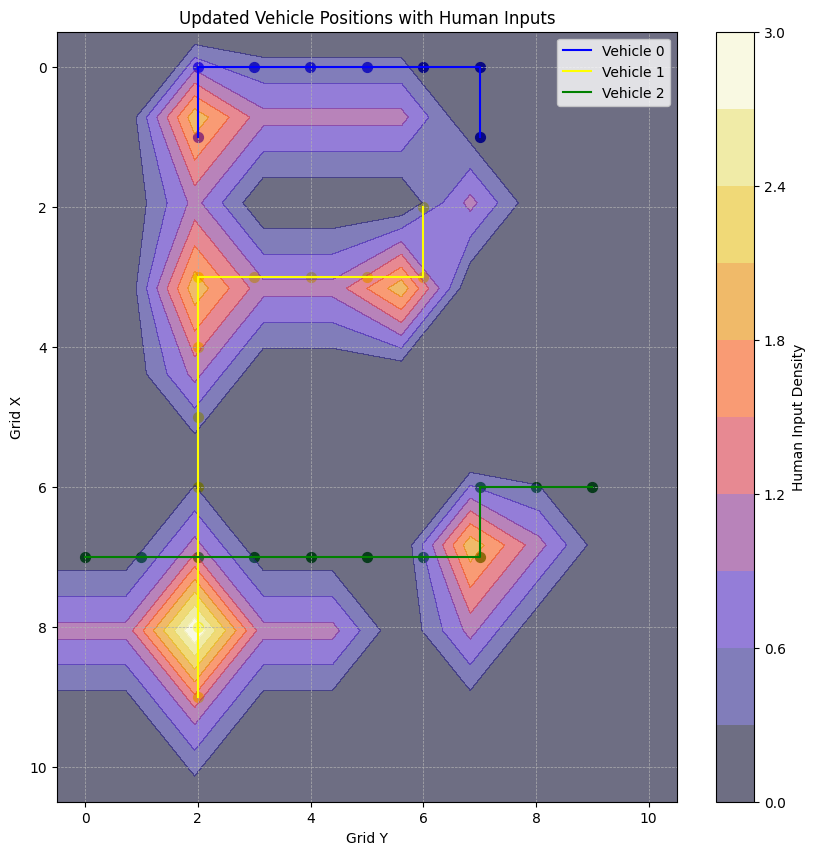

In [ ]:
# Generate human inputs: random numbers between -1 and 1, mostly zeros
np.random.seed(42)  # For reproducibility
human_inputs = {
    vehicle_id: [
        0 if np.random.random() > 0.8 else np.random.uniform(-1, 1)
        for _ in range(len(vehicle_velocities[vehicle_id]))
    ]
    for vehicle_id in vehicle_velocities.keys()
}

# Combine velocities with human inputs
actual_velocities = {
    vehicle_id: [
        max(0, vehicle_velocities[vehicle_id][t] + human_inputs[vehicle_id][t])
        for t in range(len(vehicle_velocities[vehicle_id]))
    ]
    for vehicle_id in vehicle_velocities.keys()
}

# Recalculate positions based on actual velocities
new_positions = {v: [] for v in trajectories}

for vehicle_id, trajectory in trajectories.items():
    total_time = 0
    current_position = trajectory[0]  # Start at the first position
    new_positions[vehicle_id].append(current_position)

    for t in range(1, len(trajectory)):
        dx = trajectory[t][0] - current_position[0]
        dy = trajectory[t][1] - current_position[1]
        distance = np.sqrt(dx**2 + dy**2)
        velocity = actual_velocities[vehicle_id][t - 1]

        if distance <= velocity:
            # Move to the next point
            current_position = trajectory[t]
        else:
            # Partial movement towards the next point
            fraction = velocity / distance
            new_x = current_position[0] + fraction * dx
            new_y = current_position[1] + fraction * dy
            current_position = (new_x, new_y)

        new_positions[vehicle_id].append(current_position)

# Create a grid to track human input density
grid_size = (10, 10)  # Define the grid size
margin = 0.5
x_min, x_max = 0 - margin, grid_size[0] + margin
y_min, y_max = 0 - margin, grid_size[1] + margin
density_grid = np.zeros(grid_size)

# Map human inputs to grid coordinates (swapping axes for alignment)
for vehicle_id, trajectory in trajectories.items():
    for t, (y, x) in enumerate(trajectory):
        if human_inputs[vehicle_id][t] != 0:  # Human input occurred
            # Swap x and y axes and convert to grid indices
            grid_y = int((x - x_min) / (x_max - x_min) * (grid_size[1] - 1))
            grid_x = int((y - y_min) / (y_max - y_min) * (grid_size[0] - 1)) + 1
            if 0 <= grid_x < grid_size[0] and 0 <= grid_y < grid_size[1]:
                density_grid[grid_x, grid_y] += 1

# Visualization: Updated Vehicle Positions with Rotated Axes
plt.figure(figsize=(10, 10))
plt.title("Updated Vehicle Positions with Human Inputs")
plt.xlabel("Grid Y")
plt.ylabel("Grid X")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

colors = ['blue', 'yellow', 'green']

for vehicle_id, positions in new_positions.items():
    x_coords, y_coords = zip(*positions)  # Extract X and Y coordinates
    plt.plot(y_coords, x_coords, label=f"Vehicle {vehicle_id}", color=colors[vehicle_id])
    plt.scatter(y_coords, x_coords, color=colors[vehicle_id], s=50)

# Add contour map for human input density (adjusting swapped axes)
X, Y = np.meshgrid(
    np.linspace(y_min, y_max, grid_size[1]),
    np.linspace(x_min, x_max, grid_size[0])
)
plt.contourf(X, Y, density_grid, levels=10, cmap="CMRmap", alpha=0.6)
plt.colorbar(label="Human Input Density")

# Invert the Y-axis to make Grid X start from the upper side
plt.gca().invert_yaxis()

# Add legend and show plot
plt.legend()
plt.show()


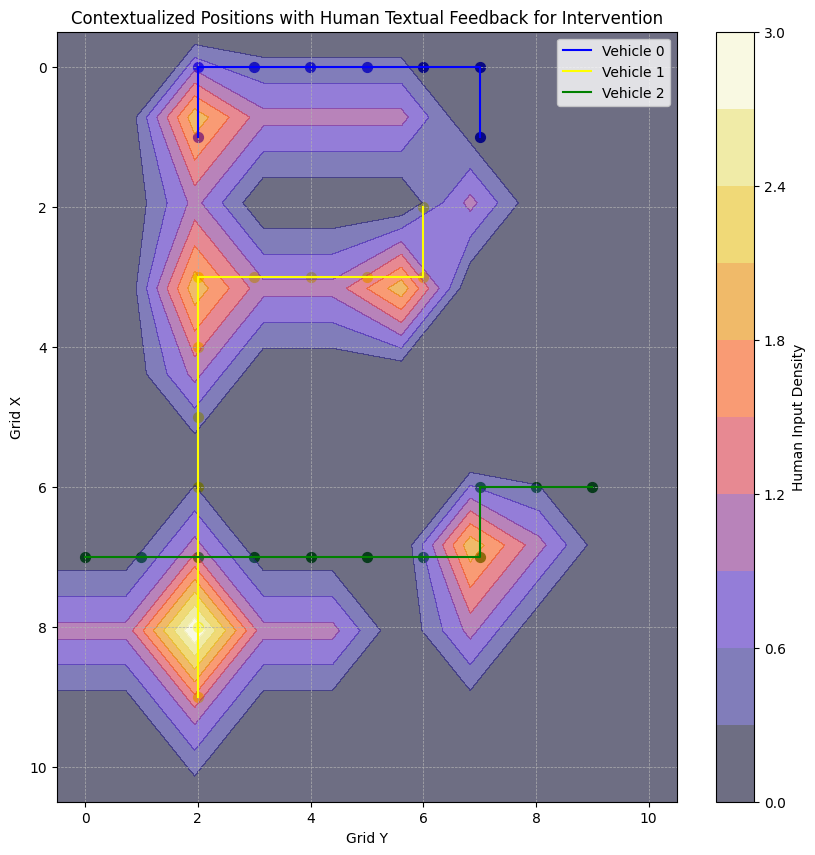

Please close the plot window to proceed with feedback collection.
Vehicle 0 at time 0 has a large input (0.90).
Provide additional context: Synchronizing with manual loading/unloading during worker handovers to avoid delays
Vehicle 0 at time 5 has a large input (0.94).
Provide additional context: Loss of GPS signals
Vehicle 1 at time 0 has a large input (-0.80).
Provide additional context: Temporarily halting to queue and wait for the delivery vehicle to unload materials
Vehicle 1 at time 3 has a large input (0.82).
Provide additional context: Fast passing near unfinished structures that pose risks of falling debris
Vehicle 1 at time 8 has a large input (0.88).
Provide additional context: Limited visibility
Vehicle 1 at time 10 has a large input (0.84).
Provide additional context: Cautious maneuvers around loose gravel
Vehicle 2 at time 2 has a large input (-0.85).
Provide additional context: Slowing down to navigate uneven terrain (a pothole) to prevent tipping and damage to the paylo

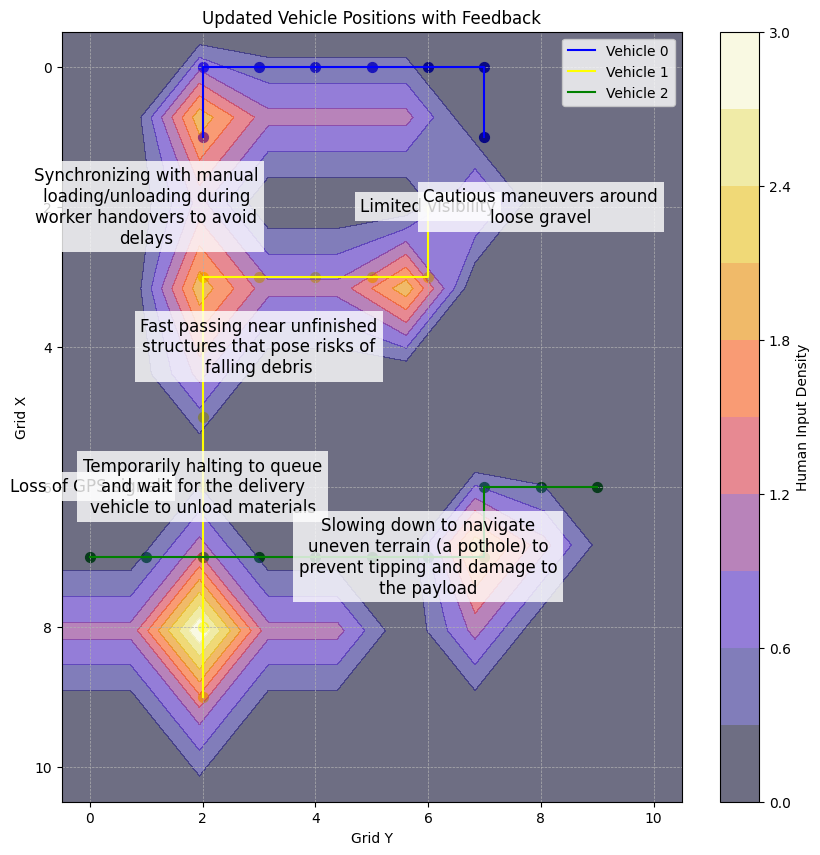

In [ ]:
import json
import textwrap

# Generate human inputs: random numbers between -1 and 1, mostly zeros
np.random.seed(42)  # For reproducibility
human_inputs = {
    vehicle_id: [
        0 if np.random.random() > 0.8 else np.random.uniform(-1, 1)
        for _ in range(len(vehicle_velocities[vehicle_id]))
    ]
    for vehicle_id in vehicle_velocities.keys()
}

# Combine velocities with human inputs
actual_velocities = {
    vehicle_id: [
        max(0, vehicle_velocities[vehicle_id][t] + human_inputs[vehicle_id][t])
        for t in range(len(vehicle_velocities[vehicle_id]))
    ]
    for vehicle_id in vehicle_velocities.keys()
}

# Recalculate positions based on actual velocities
new_positions = {v: [] for v in trajectories}

for vehicle_id, trajectory in trajectories.items():
    total_time = 0
    current_position = trajectory[0]  # Start at the first position
    new_positions[vehicle_id].append(current_position)

    for t in range(1, len(trajectory)):
        dx = trajectory[t][0] - current_position[0]
        dy = trajectory[t][1] - current_position[1]
        distance = np.sqrt(dx**2 + dy**2)
        velocity = actual_velocities[vehicle_id][t - 1]

        if distance <= velocity:
            # Move to the next point
            current_position = trajectory[t]
        else:
            # Partial movement towards the next point
            fraction = velocity / distance
            new_x = current_position[0] + fraction * dx
            new_y = current_position[1] + fraction * dy
            current_position = (new_x, new_y)

        new_positions[vehicle_id].append(current_position)

# Create a grid to track human input density
grid_size = (10, 10)  # Define the grid size
margin = 0.5
x_min, x_max = 0 - margin, grid_size[0] + margin
y_min, y_max = 0 - margin, grid_size[1] + margin
density_grid = np.zeros(grid_size)

# Map human inputs to grid coordinates (swapping axes for alignment)
for vehicle_id, trajectory in trajectories.items():
    for t, (y, x) in enumerate(trajectory):
        if human_inputs[vehicle_id][t] != 0:  # Human input occurred
            # Swap x and y axes and convert to grid indices
            grid_y = int((x - x_min) / (x_max - x_min) * (grid_size[1] - 1))
            grid_x = int((y - y_min) / (y_max - y_min) * (grid_size[0] - 1)) + 1
            if 0 <= grid_x < grid_size[0] and 0 <= grid_y < grid_size[1]:
                density_grid[grid_x, grid_y] += 1


def get_user_feedback(vehicle_id, time, input_value):
    # Use text input in a headless environment
    print(f"Vehicle {vehicle_id} at time {time} has a large input ({input_value:.2f}).")
    feedback = input("Provide additional context: ")
    return feedback

# Threshold for large human inputs
large_input_threshold = 0.8
user_feedback_data = {}

# Detect large human inputs and store their positions for feedback
feedback_positions = []
for vehicle_id, inputs in human_inputs.items():
    trajectory_length = len(trajectories[vehicle_id])
    for t, input_value in enumerate(inputs[:trajectory_length]):  # Ensure index alignment
        if abs(input_value) > large_input_threshold:  # Large input detected
            trajectory_position = trajectories[vehicle_id][t]
            feedback_positions.append((vehicle_id, t, trajectory_position, input_value))


# Show the plot first
plt.figure(figsize=(10, 10))
plt.title("Contextualized Positions with Human Textual Feedback for Intervention")
plt.xlabel("Grid Y")
plt.ylabel("Grid X")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

colors = ['blue', 'yellow', 'green']

# Plot vehicle trajectories
for vehicle_id, positions in new_positions.items():
    x_coords, y_coords = zip(*positions)  # Extract X and Y coordinates
    plt.plot(y_coords, x_coords, label=f"Vehicle {vehicle_id}", color=colors[vehicle_id])
    plt.scatter(y_coords, x_coords, color=colors[vehicle_id], s=50)

# Add contour map for human input density
X, Y = np.meshgrid(
    np.linspace(y_min, y_max, grid_size[1]),
    np.linspace(x_min, x_max, grid_size[0])
)
plt.contourf(X, Y, density_grid, levels=10, cmap="CMRmap", alpha=0.6)
plt.colorbar(label="Human Input Density")

# Invert the Y-axis to make Grid X start from the upper side
plt.gca().invert_yaxis()
plt.legend()
plt.pause(1) # Pause to render the plot and allow interaction
# plt.show()

# Prompt user for feedback after they manually close the plot
print("Please close the plot window to proceed with feedback collection.")
plt.show(block=True)  # Blocks until the plot window is closed

# Prompt user for feedback
for vehicle_id, time, position, input_value in feedback_positions:
    feedback = get_user_feedback(vehicle_id, time, input_value)
    if feedback:
        if vehicle_id not in user_feedback_data:
            user_feedback_data[vehicle_id] = {}
        user_feedback_data[vehicle_id][time] = {
            "position": position,
            "input_value": input_value,
            "feedback": feedback,
        }

# # Save feedback locally to a file
# with open("user_feedback.json", "w") as file:
#     json.dump(user_feedback_data, file, indent=4)

# Overlay text annotations for feedback on the plot
plt.figure(figsize=(10, 10))
plt.title("Updated Vehicle Positions with Feedback")
plt.xlabel("Grid Y")
plt.ylabel("Grid X")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Plot vehicle trajectories again
for vehicle_id, positions in new_positions.items():
    x_coords, y_coords = zip(*positions)
    plt.plot(y_coords, x_coords, label=f"Vehicle {vehicle_id}", color=colors[vehicle_id])
    plt.scatter(y_coords, x_coords, color=colors[vehicle_id], s=50)

# Add contour map again
plt.contourf(X, Y, density_grid, levels=10, cmap="CMRmap", alpha=0.6)
plt.colorbar(label="Human Input Density")

# Overlay feedback as annotations
for vehicle_id, feedbacks in user_feedback_data.items():
    for time, data in feedbacks.items():
        y, x = data["position"]
        feedback_text = data["feedback"]

        # Wrap the feedback text to fit within a certain character limit per line
        wrapped_text = "\n".join(textwrap.wrap(feedback_text, width=30))  # Adjust width as needed

        plt.text(
            y, x, wrapped_text,
            fontsize=12, color="black", ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
        )

plt.gca().invert_yaxis()
plt.legend()

# Save the figure if a path is provided
save_path="human_input.png"

if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"Visualization saved as {save_path}")

plt.show()